In [3]:
# %pip install ultralytics scikit-learn seaborn --quiet
import os
import cv2
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from ultralytics import YOLO

# # Verify dataset structure
# dataset_path = "./C2A-Dataset/C2A_Dataset/new_dataset3"
# assert os.path.exists(f"{dataset_path}/train/images"), "Train images missing!"
# assert os.path.exists(f"{dataset_path}/All labels with Pose information/labels"), "Pose labels missing!"
# print("✅ Dataset verified!")

In [4]:
# Verify dataset structure
dataset_path = "./C2A_Dataset/new_dataset3"
train_images_path = f"{dataset_path}/train/images"
pose_labels_path = f"{dataset_path}/All labels with Pose information/labels"

print("Checking path:", train_images_path)
if not os.path.exists(train_images_path):
	raise FileNotFoundError(f"Train images missing at: {train_images_path}")

print("Checking path:", pose_labels_path)
if not os.path.exists(pose_labels_path):
	raise FileNotFoundError(f"Pose labels missing at: {pose_labels_path}")

print("✅ Dataset verified!")

Checking path: ./C2A_Dataset/new_dataset3/train/images
Checking path: ./C2A_Dataset/new_dataset3/All labels with Pose information/labels
✅ Dataset verified!


100%|██████████| 6129/6129 [01:24<00:00, 72.64it/s]


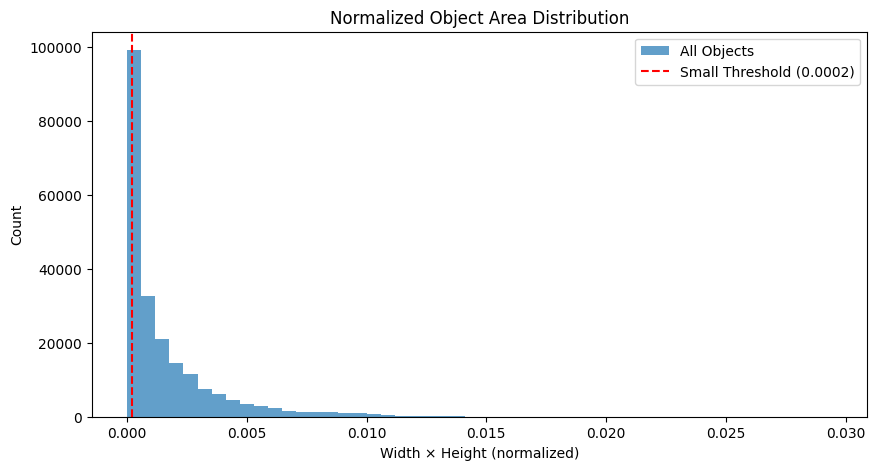

In [5]:
#Object Size Distribution
def get_object_sizes(label_dir):
    sizes = []
    # for label_file in tqdm(os.listdir(label_dir)[:6129]):  # Sample for speed
    for label_file in tqdm(os.listdir(label_dir)):  # Sample for speed
        with open(os.path.join(label_dir, label_file), 'r') as f:
            for line in f:
                _, _, _, w, h = map(float, line.strip().split())
                sizes.append(w * h)
    return sizes

sizes = get_object_sizes(f"{dataset_path}/train/labels")
small_threshold = np.percentile(sizes, 25)  # Dynamic threshold

plt.figure(figsize=(10, 5))
plt.hist(sizes, bins=50, alpha=0.7, label='All Objects')
plt.axvline(small_threshold, color='r', linestyle='--', label=f'Small Threshold ({small_threshold:.4f})')
plt.title("Normalized Object Area Distribution")
plt.xlabel("Width × Height (normalized)")
plt.ylabel("Count")
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:13<00:00, 71.65it/s]


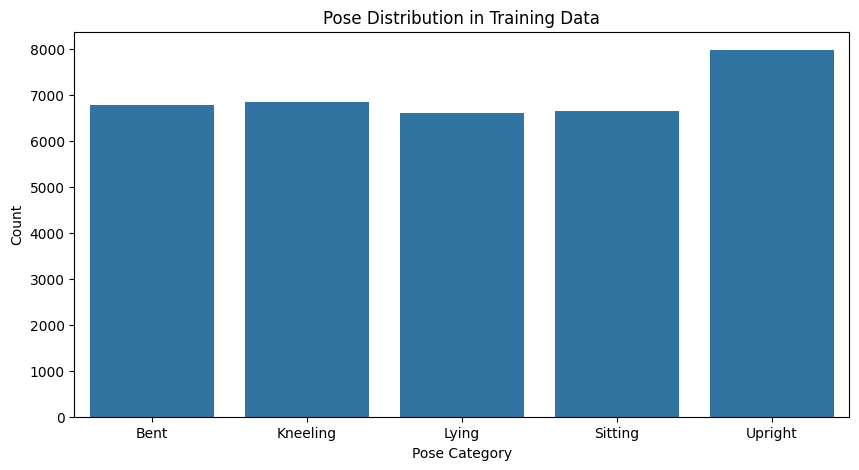

In [6]:
pose_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}  # 0:Bent, 1:Kneeling, 2:Lying, 3:Sitting, 4:Upright

# Iterate through label files
label_dir = f"{dataset_path}/All labels with Pose information/labels"
for pose_file in tqdm(os.listdir(label_dir)[:1000]):
    file_path = os.path.join(label_dir, pose_file)
    with open(file_path, 'r') as f:
        for line in f:  # Read ALL lines in the file
            parts = line.strip().split()
            if len(parts) > 5:  # Check if pose ID exists
                try:
                    pose_id = int(parts[5])
                    if pose_id in pose_counts:  # Ensure valid pose ID
                        pose_counts[pose_id] += 1
                except (ValueError, IndexError):
                    continue  # Skip invalid entries

# Plotting
plt.figure(figsize=(10, 5))
sns.barplot(x=list(pose_counts.keys()), y=list(pose_counts.values()))
plt.xticks([0, 1, 2, 3, 4], ['Bent', 'Kneeling', 'Lying', 'Sitting', 'Upright'])
plt.title("Pose Distribution in Training Data")
plt.xlabel("Pose Category")
plt.ylabel("Count")
plt.show()

In [7]:
# Dataset statistics: counts, splits, aspect ratios, anomalies
import os
import cv2
import numpy as np
from collections import Counter

# Candidate paths (handle underscore vs dash)
candidates = [
    "./C2A_Dataset/new_dataset3",
    "./C2A-Dataset/new_dataset3",
    "./C2A_Dataset/C2A_Dataset/new_dataset3",
]

dataset_path = None
for p in candidates:
    if os.path.exists(p):
        dataset_path = p
        break

if dataset_path is None:
    raise FileNotFoundError(f"None of the candidate dataset paths exist. Tried: {candidates}")

print("Using dataset_path:", dataset_path)

# folders we expect
folders = {
    'train_images': os.path.join(dataset_path, 'train', 'images'),
    'train_labels': os.path.join(dataset_path, 'train', 'labels'),
    'val_images': os.path.join(dataset_path, 'val', 'images'),
    'val_labels': os.path.join(dataset_path, 'val', 'labels'),
    'test_images': os.path.join(dataset_path, 'test', 'images'),
    'test_labels': os.path.join(dataset_path, 'test', 'labels'),
    'pose_labels': os.path.join(dataset_path, 'All labels with Pose information', 'labels'),
}

# helper
IMAGE_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}

def count_files(dirpath, exts=None):
    if not os.path.exists(dirpath):
        return 0
    exts = exts or IMAGE_EXTS
    cnt = 0
    for fn in os.listdir(dirpath):
        if os.path.splitext(fn)[1].lower() in exts:
            cnt += 1
    return cnt

stats = {}
for k, p in folders.items():
    stats[k] = count_files(p, IMAGE_EXTS if 'images' in k else {'.txt'})

# derive totals and splits
train_n = stats['train_images']
val_n = stats['val_images']
test_n = stats['test_images']

total_images = train_n + val_n + test_n

if total_images > 0:
    splits = {
        'train_pct': train_n / total_images * 100,
        'val_pct': val_n / total_images * 100,
        'test_pct': test_n / total_images * 100,
    }
else:
    splits = {'train_pct': 0, 'val_pct': 0, 'test_pct': 0}

# Basic print
print('\nDataset file counts:')
for k in ['train_images','val_images','test_images','train_labels','pose_labels']:
    print(f" - {k}: {stats.get(k, 0)}")

print('\nSplits (by image count):')
print(f" train: {train_n} ({splits['train_pct']:.2f}%)")
print(f" val:   {val_n} ({splits['val_pct']:.2f}%)")
print(f" test:  {test_n} ({splits['test_pct']:.2f}%)")

# Aspect ratio sampling (sample up to 500 images from train)
def sample_aspect_ratios(img_dir, sample_n=500):
    ratios = []
    if not os.path.exists(img_dir):
        return ratios
    files = [f for f in os.listdir(img_dir) if os.path.splitext(f)[1].lower() in IMAGE_EXTS]
    if not files:
        return ratios
    import random
    sample = files if len(files) <= sample_n else random.sample(files, sample_n)
    for fn in sample:
        p = os.path.join(img_dir, fn)
        img = cv2.imread(p)
        if img is None:
            continue
        h, w = img.shape[:2]
        ratios.append(w / h)
    return ratios

ratios = sample_aspect_ratios(folders['train_images'], sample_n=50000)
if ratios:
    arr = np.array(ratios)
    print('\nAspect ratio (w/h) stats for sampled train images:')
    print(f" mean={arr.mean():.3f}, median={np.median(arr):.3f}, min={arr.min():.3f}, max={arr.max():.3f}")
else:
    print('\nNo images found to compute aspect ratios.')

# Anomalies: images without labels and labels without images (for train)
def basename_noext(fn):
    return os.path.splitext(fn)[0]

images = set([basename_noext(f) for f in os.listdir(folders['train_images']) if os.path.splitext(f)[1].lower() in IMAGE_EXTS]) if os.path.exists(folders['train_images']) else set()
labels = set([basename_noext(f) for f in os.listdir(folders['train_labels']) if os.path.splitext(f)[1].lower() == '.txt']) if os.path.exists(folders['train_labels']) else set()

images_without_labels = sorted(list(images - labels))[:20]
labels_without_images = sorted(list(labels - images))[:20]

print(f"\nSample anomalies (showing up to 20 items):")
print(f" - images without labels: {len(images - labels)} (example: {images_without_labels[:5]})")
print(f" - labels without images: {len(labels - images)} (example: {labels_without_images[:5]})")

# Save a small summary dict for programmatic use
summary = {
    'dataset_path': dataset_path,
    'counts': stats,
    'splits_pct': splits,
    'total_images': total_images,
    'aspect_ratio_sample_n': len(ratios),
    'aspect_ratio_stats': {
        'mean': float(arr.mean()) if len(ratios) else None,
        'median': float(np.median(arr)) if len(ratios) else None,
        'min': float(arr.min()) if len(ratios) else None,
        'max': float(arr.max()) if len(ratios) else None,
    } if len(ratios) else None,
    'anomalies_sample': {
        'images_without_labels_example': images_without_labels,
        'labels_without_images_example': labels_without_images,
    }
}

# Display small DataFrame-like view if pandas available
try:
    import pandas as pd
    df = pd.DataFrame([(
        'train', train_n, stats.get('train_labels', 0), splits['train_pct']),
        ('val', val_n, stats.get('val_labels', 0), splits['val_pct']),
        ('test', test_n, stats.get('test_labels', 0), splits['test_pct'])
    ], columns=['split','images','labels','pct'])
    print('\nSummary table:')
    print(df.to_string(index=False))
except Exception:
    pass

# Make `summary` available in notebook
_summary = summary
print('\nSummary dictionary stored in variable `_summary`')


Using dataset_path: ./C2A_Dataset/new_dataset3

Dataset file counts:
 - train_images: 6129
 - val_images: 2043
 - test_images: 2043
 - train_labels: 6129
 - pose_labels: 10215

Splits (by image count):
 train: 6129 (60.00%)
 val:   2043 (20.00%)
 test:  2043 (20.00%)

Aspect ratio (w/h) stats for sampled train images:
 mean=1.136, median=1.019, min=0.570, max=2.235

Sample anomalies (showing up to 20 items):
 - images without labels: 0 (example: [])
 - labels without images: 0 (example: [])

Summary table:
split  images  labels  pct
train    6129    6129 60.0
  val    2043    2043 20.0
 test    2043    2043 20.0

Summary dictionary stored in variable `_summary`


In [8]:
# ...existing code...
import os, cv2, random, numpy as np
from tqdm import tqdm

OUT = "./working/augmentation_preview"
os.makedirs(OUT, exist_ok=True)

# helper simple augmentations (cv2-only, no extra deps)
def flip_h(img): return cv2.flip(img, 1)
def rotate(img, angle):
    h,w = img.shape[:2]; M = cv2.getRotationMatrix2D((w/2,h/2), angle, 1.0)
    return cv2.warpAffine(img, M, (w,h), borderMode=cv2.BORDER_REFLECT)
def brightness(img, alpha=1.2, beta=10): return cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
def blur(img, k=5): return cv2.GaussianBlur(img, (k|1,k|1), 0)
def add_noise(img, std=15):
    noise = np.random.normal(0, std, img.shape).astype(np.int16)
    out = img.astype(np.int16)+noise
    return np.clip(out,0,255).astype(np.uint8)
def occlude(img, frac=0.25):
    h,w = img.shape[:2]; wh = int(min(h,w)*frac)
    x = random.randint(0, w-wh); y = random.randint(0, h-wh)
    out = img.copy(); out[y:y+wh, x:x+wh] = (0,0,0)
    return out
def extreme_crop(img, keep=0.5):
    h,w = img.shape[:2]; ch, cw = int(h*keep), int(w*keep)
    y = random.randint(0, h-ch); x = random.randint(0, w-cw)
    c = img[y:y+ch, x:x+cw]
    return cv2.resize(c, (w,h))

# define augmentation groups
normal_ag = [
    ("flip", flip_h),
    ("rotate15", lambda i: rotate(i, 15)),
    ("bright", lambda i: brightness(i, 1.2, 15)),
    ("blur", lambda i: blur(i, 5)),
    ("noise", lambda i: add_noise(i, 10)),
]

anomaly_ag = [
    ("occlusion", lambda i: occlude(i, 0.35)),
    ("heavy_blur", lambda i: blur(i, 21)),
    ("extreme_bright", lambda i: brightness(i, 2.0, 60)),
    ("extreme_crop", lambda i: extreme_crop(i, 0.4)),
    ("channel_swap", lambda i: cv2.cvtColor(i, cv2.COLOR_BGR2RGB)),
]

# sample images
train_img_dir = os.path.join(dataset_path, "train", "images")
files = [f for f in os.listdir(train_img_dir) if os.path.splitext(f)[1].lower() in {'.jpg','.png','.jpeg'}]
sample = files if len(files) <= 6 else random.sample(files, 6)

def make_grid(imgs, cols=3):
    rows = []
    for r in range(0, len(imgs), cols):
        row = np.hstack([imgs[r+i] if r+i < len(imgs) else np.zeros_like(imgs[0]) for i in range(cols)])
        rows.append(row)
    return np.vstack(rows)

# generate previews
for idx, fn in enumerate(sample):
    p = os.path.join(train_img_dir, fn)
    img = cv2.imread(p)
    if img is None: continue
    H,W = img.shape[:2]
    # normal group: original + 4 normals
    normal_imgs = [cv2.resize(img, (640, int(640*H/W)))]
    for name, f in normal_ag[:4]:
        normal_imgs.append(cv2.resize(f(img.copy()), (640, int(640*H/W))))
    grid_n = make_grid([cv2.copyMakeBorder(i,0,0,0,0,cv2.BORDER_CONSTANT, value=(255,255,255)) for i in normal_imgs], cols=3)
    cv2.imwrite(os.path.join(OUT, f"{idx:02d}_normal_{fn}"), grid_n)

    # anomaly group: original + 4 anomalies
    anomaly_imgs = [cv2.resize(img, (640, int(640*H/W)))]
    for name, f in anomaly_ag[:4]:
        anomaly_imgs.append(cv2.resize(f(img.copy()), (640, int(640*H/W))))
    grid_a = make_grid([cv2.copyMakeBorder(i,0,0,0,0,cv2.BORDER_CONSTANT, value=(255,255,255)) for i in anomaly_imgs], cols=3)
    cv2.imwrite(os.path.join(OUT, f"{idx:02d}_anomaly_{fn}"), grid_a)

print("Saved preview images to", OUT)
# ...existing code...

Saved preview images to ./working/augmentation_preview


Loaded image: ./C2A_Dataset/new_dataset3/train/images/collapsed_building_image0001_0.png with shape (288, 281, 3)
Loaded image: ./C2A_Dataset/new_dataset3/train/images/fire_image0001_0.png with shape (359, 332, 3)
Loaded image: ./C2A_Dataset/new_dataset3/train/images/flood_image0001_0.png with shape (394, 700, 3)
Loaded image: ./C2A_Dataset/new_dataset3/train/images/traffic_incident_image0001_0.png with shape (281, 293, 3)


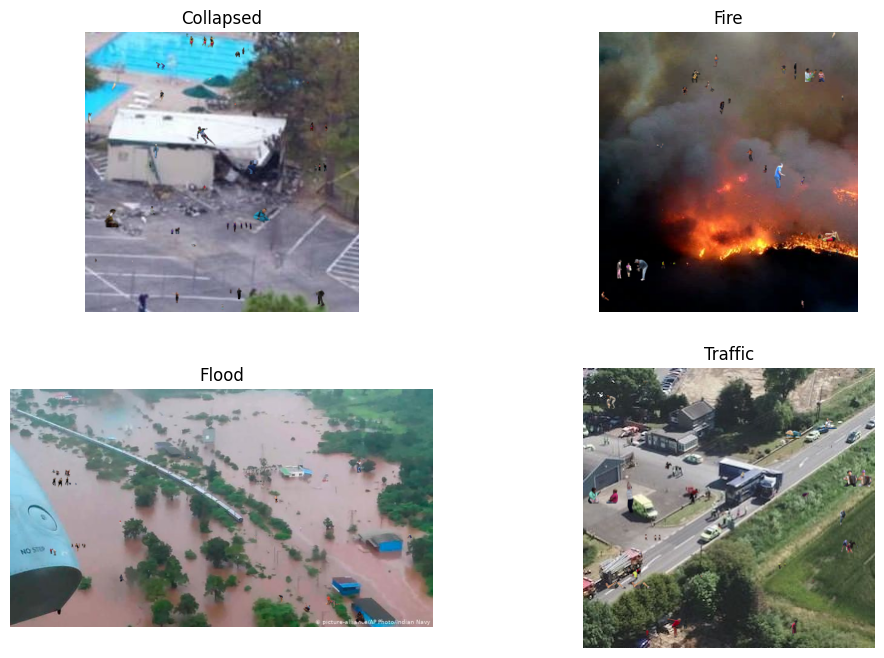

In [12]:
img_collapse = './C2A_Dataset/new_dataset3/train/images/collapsed_building_image0001_0.png'
img_fire = './C2A_Dataset/new_dataset3/train/images/fire_image0001_0.png'
img_flood = './C2A_Dataset/new_dataset3/train/images/flood_image0001_0.png'
img_traffic = './C2A_Dataset/new_dataset3/train/images/traffic_incident_image0001_0.png'

s = [img_collapse, img_fire, img_flood, img_traffic]
for p in s:
    img = cv2.imread(p)
    if img is None:
        print(f"Failed to load image: {p}")
    else:
        print(f"Loaded image: {p} with shape {img.shape}")

plt.figure(figsize=(12, 8))
for i, p in enumerate(s):
    img = cv2.imread(p)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 2, i+1)
        plt.imshow(img)
        plt.title(os.path.basename(p).split('_')[0].capitalize())
        plt.axis('off')

In [72]:
base_yaml = {
    "path": dataset_path,
    "train": "train/images",
    "val": "val/images",
    "names": {0: "human"},
    "nc": 1,
    "augment": True
}

# Ensure val path is correct (not duplicated)
# base_yaml["val"] = f"{dataset_path}/val/images"
with open("./working/c2a.yaml", "w") as f:
    yaml.dump(base_yaml, f)

In [13]:
with open("./working/c2a.yaml", "r") as f:
    print(f.read())

augment: true
names:
  0: human
nc: 1
path: ./C2A_Dataset/new_dataset3
train: train/images
val: val/images



In [33]:
#Small-Object Config (Dynamic Threshold)
small_images = []
for label_file in tqdm(os.listdir(f"{dataset_path}/train/labels")[:6129]):
    with open(os.path.join(f"{dataset_path}/train/labels", label_file), 'r') as f:
        if any(float(line.split()[3]) * float(line.split()[4]) < small_threshold for line in f):
            small_images.append(f"{dataset_path}/train/images/{label_file.replace('.txt', '.png')}")

with open("./working/train_small.txt", "w") as f:
    f.write("\n".join(small_images))

100%|██████████| 6129/6129 [00:01<00:00, 4001.26it/s]


In [34]:
small_yaml = {
    "path": dataset_path,
    "train": "./working/train_small.txt",
    "val": f"{dataset_path}/val/images",
    "names": {0: "human"},
    "nc": 1,
    "augment": True,
    "mosaic": 1.0  # Enhanced augmentation
}
with open("./working/c2a_small.yaml", "w") as f:
    yaml.dump(small_yaml, f)

In [35]:
with open("./working/c2a_small.yaml", "r") as f:
    print(f.read())

augment: true
mosaic: 1.0
names:
  0: human
nc: 1
path: ./C2A_Dataset/new_dataset3
train: ./working/train_small.txt
val: ./C2A_Dataset/new_dataset3/val/images



In [74]:
from IPython.display import FileLink

# Stage 1: Train on all data
model = YOLO("yolov9e.pt")
results = model.train(
    data="./working/c2a.yaml",
    epochs=25,
    imgsz=640,
    batch=8,
    device=0,
    project="./working",  # Force save to working dir
    name="stage1_all_data",
    exist_ok=True
)

# Verify and display checkpoint
!ls ./working/stage1_all_data/weights  # Check files
stage1_ckpt = "./working/stage1_all_data/weights/last.pt"
assert os.path.exists(stage1_ckpt), "Stage 1 failed - no checkpoint generated"
FileLink(stage1_ckpt)  # Click to download/view in Kaggle

# Stage 2: Train on small objects
model = YOLO(stage1_ckpt)
model.train(
    data="./working/c2a_small.yaml",
    epochs=25,
    imgsz=640,
    batch=8,
    device=0,
    project="./working",
    name="stage2_small_objects",
    exist_ok=True
)

print("✅ Training completed! Check files:")
!ls ./working/stage*  # Verify both stages

Ultralytics 8.3.199  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./working/c2a.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9e.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=stage1_all_data, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, 

KeyboardInterrupt: 